<a href="https://colab.research.google.com/github/Gliitchhh410/PyTorch_Fundmentals/blob/main/08_Vision_Transformer_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cce86f970d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

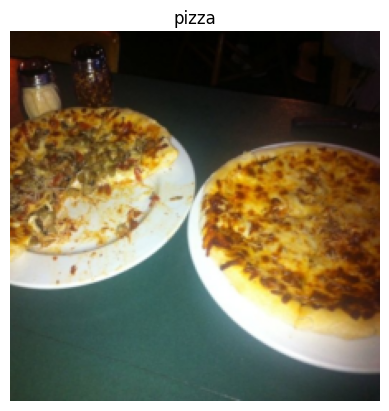

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


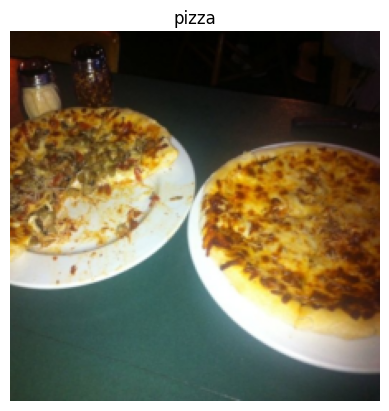

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

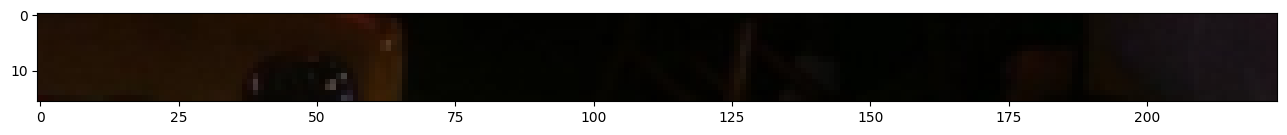

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


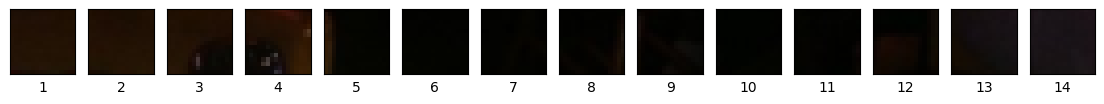

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


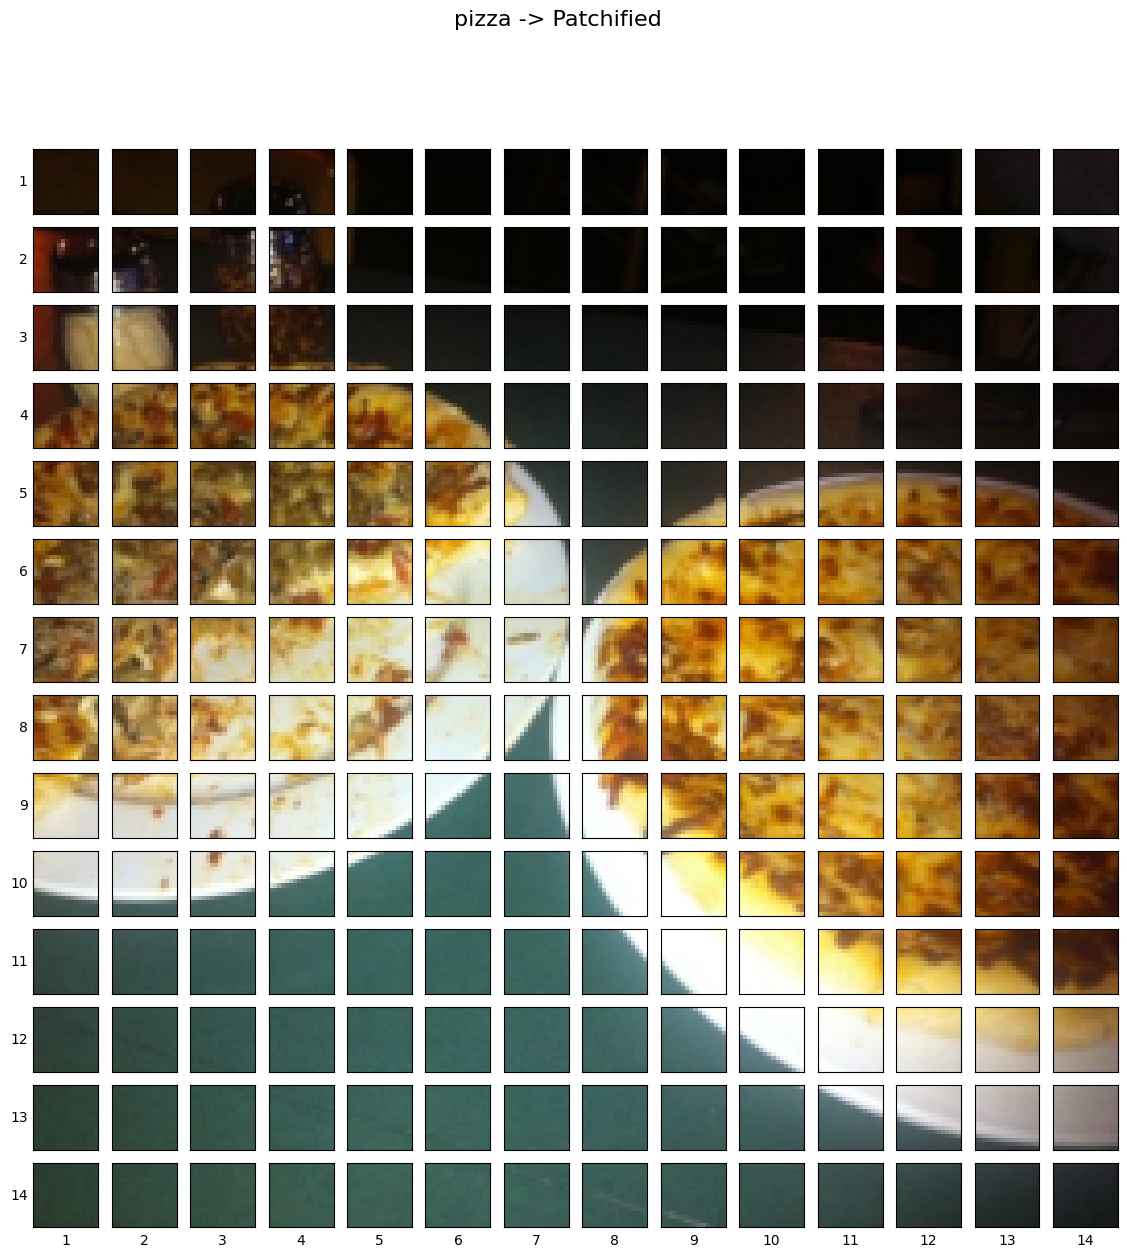

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn



patch_size = 16



conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size= patch_size,
                   stride = patch_size,
                   padding= 0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

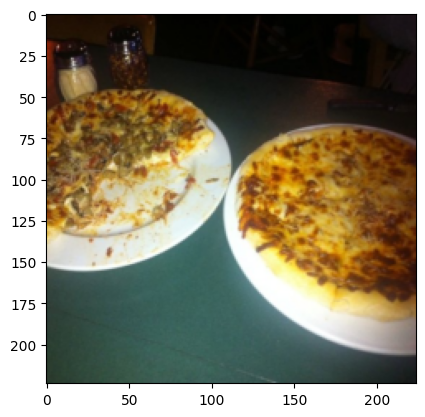

In [17]:
plt.imshow(image.permute(1, 2, 0))

In [18]:
image_out_of_conv2d = conv2d(image.unsqueeze(0))
image_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [659, 603, 643, 392, 511]


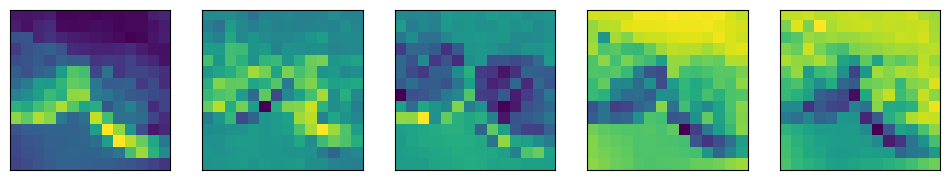

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv2d[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv2d[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-1.4480e-02, -1.5844e-02, -1.6595e-02, -2.2087e-02, -2.1971e-02,
            2.9346e-03, -1.5342e-04,  5.2915e-03,  2.6527e-03,  1.2140e-03,
           -3.8389e-03,  1.9399e-02, -3.9982e-04,  9.6404e-03],
          [-6.5607e-02,  1.0498e-01,  2.7044e-02, -4.2371e-02, -1.0946e-02,
            1.4092e-02,  7.7374e-03, -5.7390e-03, -1.7026e-03,  1.5729e-03,
           -2.4272e-03,  1.2631e-02,  2.9704e-03, -2.1034e-02],
          [ 5.5026e-02,  1.6063e-01,  6.6166e-03,  8.5245e-02,  7.0893e-02,
            3.4873e-02,  3.1419e-02,  4.1072e-02,  4.9498e-02,  4.4268e-02,
            8.3223e-02,  4.3702e-02,  3.7203e-03,  3.5421e-03],
          [-2.1339e-02, -8.6269e-02, -1.3397e-01, -4.8217e-03, -2.7997e-02,
            2.2515e-01,  7.1717e-02,  4.5685e-02,  4.3347e-02,  3.2983e-02,
            5.4121e-03,  8.4655e-03,  1.7269e-02,  1.2632e-02],
          [-4.2793e-02, -1.1044e-01,  7.3259e-02, -1.4996e-01, -6.6395e-02,
            3.0599e-02,  4.4197e-01,  6.4360e-02,  1.0535e-0

In [21]:
print(image_out_of_conv2d.shape)
print(single_feature_map.shape)

torch.Size([1, 768, 14, 14])
torch.Size([1, 14, 14])


In [22]:
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)

flatten_layer(image_out_of_conv2d).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


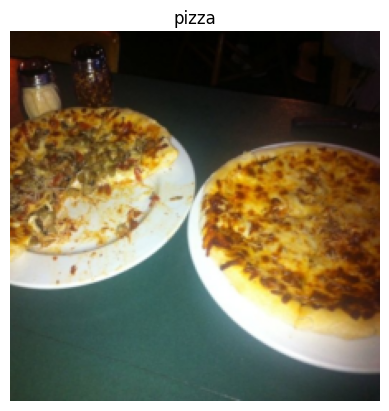

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
image_out_of_conv_flattened.permute(0,2,1).shape

torch.Size([1, 196, 768])

In [25]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]


single_flattened_feature_map

tensor([[-1.4480e-02, -1.5844e-02, -1.6595e-02, -2.2087e-02, -2.1971e-02,
          2.9346e-03, -1.5342e-04,  5.2915e-03,  2.6527e-03,  1.2140e-03,
         -3.8389e-03,  1.9399e-02, -3.9982e-04,  9.6404e-03, -6.5607e-02,
          1.0498e-01,  2.7044e-02, -4.2371e-02, -1.0946e-02,  1.4092e-02,
          7.7374e-03, -5.7390e-03, -1.7026e-03,  1.5729e-03, -2.4272e-03,
          1.2631e-02,  2.9704e-03, -2.1034e-02,  5.5026e-02,  1.6063e-01,
          6.6166e-03,  8.5245e-02,  7.0893e-02,  3.4873e-02,  3.1419e-02,
          4.1072e-02,  4.9498e-02,  4.4268e-02,  8.3223e-02,  4.3702e-02,
          3.7203e-03,  3.5421e-03, -2.1339e-02, -8.6269e-02, -1.3397e-01,
         -4.8217e-03, -2.7997e-02,  2.2515e-01,  7.1717e-02,  4.5685e-02,
          4.3347e-02,  3.2983e-02,  5.4121e-03,  8.4655e-03,  1.7269e-02,
          1.2632e-02, -4.2793e-02, -1.1044e-01,  7.3259e-02, -1.4996e-01,
         -6.6395e-02,  3.0599e-02,  4.4197e-01,  6.4360e-02,  1.0535e-01,
          3.1131e-01,  1.9449e-01,  1.

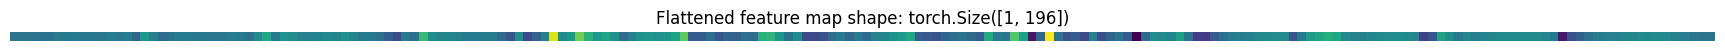

In [26]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3,
               patch_size = 16,
               embedding_int = 768,
               ):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_int,
                             kernel_size= patch_size,
                             stride = patch_size,
                             padding= 0)


    self.flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)


  def forward(self, x):
    image_resolution = x.shape[-1]

    assert image_resolution % patch_size == 0, f"Wrong input image size"
    x = self.patcher(x)
    x = self.flatten_layer(x)
    return x.permute(0,2,1)

In [28]:
set_seeds()

patchify = PatchEmbedding()


print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Output image size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output image size: torch.Size([1, 196, 768])


In [29]:
rand_image_tensor = torch.randn((1, 3, 224, 224))
rand_image_tensor_bad = torch.randn((1, 3, 250, 250))



patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [30]:
patchify(rand_image_tensor_bad)

AssertionError: Wrong input image size

In [31]:
batch_size = patch_embedded_image.shape[0]
embedding_dimenstion = patch_embedded_image.shape[-1]
batch_size, embedding_dimenstion

(1, 768)

In [32]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimenstion),
                           requires_grad = True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [33]:
class_token.shape

torch.Size([1, 1, 768])

In [34]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [35]:
patch_embedded_image_with_class_embedding = torch.cat([class_token, patch_embedded_image], dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [36]:
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [37]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1074, -0.0041, -0.0331,  ...,  0.0616, -0.0538,  0.0391],
          [-0.1077, -0.0042, -0.0326,  ...,  0.0482, -0.0507,  0.0458],
          ...,
          [-0.2239,  0.0545, -0.0728,  ...,  0.1860, -0.1245,  0.0786],
          [-0.1751,  0.0346, -0.0569,  ...,  0.1488, -0.1033,  0.0633],
          [-0.1339,  0.0170, -0.0409,  ...,  0.1078, -0.0832,  0.0556]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
number_of_patches = int((height*width)/ patch_size**2)


embedding_dimenstion = patch_embedded_image_with_class_embedding.shape[-1]


position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimenstion),requires_grad = True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
patch_and_postition_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_postition_embedding, patch_and_postition_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.8926, 0.9959, 0.9669,  ..., 1.0616, 0.9462, 1.0391],
          [0.8923, 0.9958, 0.9674,  ..., 1.0482, 0.9493, 1.0458],
          ...,
          [0.7761, 1.0545, 0.9272,  ..., 1.1860, 0.8755, 1.0786],
          [0.8249, 1.0346, 0.9431,  ..., 1.1488, 0.8967, 1.0633],
          [0.8661, 1.0170, 0.9591,  ..., 1.1078, 0.9168, 1.0556]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_int=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [45]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, embedding_int=768, num_heads = 12, attn_dropout = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_int)

    self.multihead_attention = nn.MultiheadAttention(embed_dim = embedding_int,
                                                       num_heads = num_heads,
                                                       dropout = attn_dropout,
                                                     batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attention(query = x,
                                            key = x,
                                            value = x,
                                            need_weights = False)
    return attn_output

In [46]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttention(embedding_int=768, # from Table 1
                                                        num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [49]:
class MLP(nn.Module):
  def __init__(self,embedding_int = 768, mlp_size = 3072, dropout = 0.1 ):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_int)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_int,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_int),
        nn.Dropout(p=dropout))

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [51]:
# Create an instance of MLPBlock
mlp_block = MLP(embedding_int=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [52]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_int = 768,
               num_heads=12,
               mlp_size=3072,
               mlp_dropout = 0.1,
               attn_dropout = 0):
    super().__init__()

    self.msa_block = MultiHeadSelfAttention(embedding_int=embedding_int,
                                            num_heads=num_heads,
                                            attn_dropout=attn_dropout)

    self.mlp_block = MLP(embedding_int=embedding_int,
                         mlp_size=mlp_size,
                         dropout=mlp_dropout)

  def forward(self, x):
    x = x + self.msa_block(x)
    x = x + self.mlp_block(x)
    return x

In [53]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoder()

# # Print an input and output summary of our Transformer Encoder (uncommen|t for full output)
summary(model=transformer_encoder_block,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttention (msa_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [54]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [55]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x